# Stock Market Analysis and Prediction using LSTM

**Time-series Data:** là một chuỗi các điểm dữ liệu, thường bao gồm các phép đo liên tiếp được thực hiện từ cùng một nguồn trong một khoảng thời gian.

Trong notebook này, chúng ta sẽ khám phá dữ liệu từ thị trường chứng khoán, cụ thể là một số cổ phiếu ngân hàng (Agribank, BIDV, Vietinbank, VCB: Vietcombank). Chúng ta sẽ sử dụng thư viện "vnstock" để lấy thông tin cổ phiếu, và trực quan hóa các khía cạnh khác nhau của dữ liệu này. Cuối cùng, chúng ta sẽ dự đoán giá cổ phiếu trong tương lai bằng phương pháp Long Short Term Memory (LSTM).

### Import thư viện

In [ ]:
# cài đặt thư viện nếu chưa có
# !pip install vnstock

In [1]:
from vnstock import *
import os
import pandas as pd
import numpy as np

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

### Chuẩn bị dữ liệu

- Chúng ta sẽ sử dụng thư viện "vnstock" (Vietnamese Stock Library). Đây là một thư viện Python phổ biến cho việc tải dữ liệu về giá cổ phiếu, chỉ số, tin tức, và các thông tin khác liên quan đến thị trường chứng khoán Việt Nam.

**Mã chứng khoán của 4 ngân hàng trên thư viện vnstock như sau:**
- AGR: Agribank
- BID: BIDV
- CTG: Vietinbank
- VCB: Vietcombank

In [2]:
path = "stock-historical-data"
if not os.path.exists(path):
    os.makedirs(path)

# Mã chứng khoán của 4 ngân hàng
ticker = ["AGR", "BID", "CTG", "VCB"]

# Lặp qua các mã ngân hàng và lấy dữ liệu
for i, tick in enumerate(ticker):
    try:
        print(f"{i} {tick}")
        # Lấy dữ liệu từ 20-05-2019 đến 20-05-2025
        df_stock_historical_data = stock_historical_data(
            symbol=tick, start_date="2019-05-20", end_date="2025-05-20")

        # Tạo tên file CSV và lưu dữ liệu vào file CSV ở đường dẫn trên
        csv_file_name = f"stock-historical-data/{tick}-History.csv"
        df_stock_historical_data.to_csv(csv_file_name, encoding="utf-8-sig")
    except:
        print("Crawling failed:", tick)

0 AGR
1 BID
2 CTG
3 VCB


In [61]:
# Đọc dữ liệu
AGR = pd.read_csv('stock-historical-data\AGR-History.csv')
BID = pd.read_csv('stock-historical-data\BID-History.csv')
CTG = pd.read_csv('stock-historical-data\CTG-History.csv')
VCB = pd.read_csv('stock-historical-data\VCB-History.csv')

In [5]:
# Xem dữ liệu
VCB

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2019-05-20,28810,29370,28770,29240,607060,VCB
1,1,2019-05-21,29280,29500,29200,29200,473170,VCB
2,2,2019-05-22,28980,29590,28900,28980,662700,VCB
3,3,2019-05-23,29070,29320,28940,29160,378440,VCB
4,4,2019-05-24,29020,29320,28510,28680,931250,VCB
...,...,...,...,...,...,...,...,...
1497,1497,2025-05-14,57200,58800,57200,58700,8014200,VCB
1498,1498,2025-05-15,59300,59800,58700,58700,8070600,VCB
1499,1499,2025-05-16,58800,59000,57500,57500,8364800,VCB
1500,1500,2025-05-19,57400,57600,57000,57000,4784400,VCB


### Tiền xử lý

**Loại bỏ những cột không cần thiết**

In [62]:
bank_list = [AGR, BID, CTG, VCB]

# Xóa cột 'Unnamed: 0' và 'ticker'
for i in range(len(bank_list)):
    bank_list[i] = bank_list[i].drop(columns=['Unnamed: 0'])
    bank_list[i] = bank_list[i].drop(columns=['ticker'])
    bank_list[i]['time'] = pd.to_datetime(bank_list[i]['time'])

AGR, BID, CTG, VCB = bank_list

In [7]:
VCB.head(10)

,time,open,high,low,close,volume
0,2019-05-20,28810,29370,28770,29240,607060
1,2019-05-21,29280,29500,29200,29200,473170
2,2019-05-22,28980,29590,28900,28980,662700
3,2019-05-23,29070,29320,28940,29160,378440
4,2019-05-24,29020,29320,28510,28680,931250
5,2019-05-27,28900,29240,28680,29070,341320
6,2019-05-28,28900,29590,28810,29070,664400
7,2019-05-29,29160,29370,28980,29110,313510
8,2019-05-30,29110,29370,29020,29200,320900
9,2019-05-31,29110,29320,28810,28980,712090


**Giải thích ý nghĩa tên các cột:**
- time: Ngày giao dịch. Đây là cột chỉ ra ngày cụ thể mà các giao dịch này đã diễn ra, theo định dạng năm-tháng-ngày (YYYY-MM-DD).
- open: Giá mở cửa. Đây là mức giá đầu tiên được giao dịch vào ngày đó.
- high: Giá cao nhất. Đây là mức giá cao nhất mà cổ phiếu được giao dịch trong ngày.
- low: Giá thấp nhất. Đây là mức giá thấp nhất mà cổ phiếu được giao dịch trong ngày.
- close: Giá đóng cửa. Đây là mức giá cuối cùng được giao dịch vào ngày đó.
- volume: Khối lượng giao dịch. Đây là tổng số lượng cổ phiếu được giao dịch trong ngày.


> Ta thấy dữ liệu chỉ có thông tin 5 ngày/tuần(T2-T6) vì sàn giao dịch chứng khoán quy định ngày giao dịch từ thứ 2 đến thứ 6 trừ thứ 7, CN và Lễ theo quy định chung

In [8]:
# Kiểm tra xem lễ 30/4 có dữ liệu không
date = '30-4-2025'
data = VCB.loc[VCB['time'] ==  date]
data

,time,open,high,low,close,volume


### Thống kê mô tả về dữ liệu
- .describe() dùng để xem các thống kê mô tả. Thống kê mô tả bao gồm các thống kê tóm tắt về số lượng mẫu, trung bình, độ lệch chuẩn và hình dạng của phân phối dữ liệu.

In [15]:
# pd.set_option('display.float_format', '{:.0f}'.format)

In [11]:
VCB.loc[:, VCB.columns != 'time'].describe()

,open,high,low,close,volume
count,1502,1502,1502,1502,1502
mean,47455,47951,46971,47458,1296302
std,10223,10234,10194,10178,950593
min,24890,25410,24630,24890,113900
25%,39130,39560,38770,39160,761348
50%,45030,45615,44290,44970,1092440
75%,58090,58730,57545,58108,1564325
max,67800,68600,66800,67300,11887700


> Nhận xét:
- Có 1.502 điểm dữ liệu cho mỗi cột
- Giá cổ phiếu (open, high, low, close) dao động từ khoảng ~24.890 đến ~68.000, với trung bình khoảng 47.458.
- Độ lệch chuẩn cao (~10.000) cho thấy biến động giá khá lớn.
- Khối lượng giao dịch trung bình khoảng 1,3 triệu, nhưng dao động rất rộng (min: ~113.900, max: ~11,8 triệu), chứng tỏ có những phiên giao dịch đột biến.

### Thông tin về dữ liệu
- Phương thức .info() in ra thông tin về một DataFrame bao gồm kiểu dữ liệu và các cột, số lượng giá trị không bị thiếu.

In [16]:
VCB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1502 non-null   datetime64[ns]
 1   open    1502 non-null   int64         
 2   high    1502 non-null   int64         
 3   low     1502 non-null   int64         
 4   close   1502 non-null   int64         
 5   volume  1502 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 70.5 KB


### Kiểm tra dữ liệu có thiếu không

In [17]:
print(VCB.isnull().sum())

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [18]:
df = VCB.copy()
df.set_index('time',inplace=True)
df

,open,high,low,close,volume
time,,,,,
2019-05-20,28810,29370,28770,29240,607060
2019-05-21,29280,29500,29200,29200,473170
2019-05-22,28980,29590,28900,28980,662700
2019-05-23,29070,29320,28940,29160,378440
2019-05-24,29020,29320,28510,28680,931250
...,...,...,...,...,...
2025-05-14,57200,58800,57200,58700,8014200
2025-05-15,59300,59800,58700,58700,8070600
2025-05-16,58800,59000,57500,57500,8364800


### Giá đóng cửa
Giá đóng cửa là mức giá cuối cùng mà cổ phiếu được giao dịch trong phiên giao dịch chính thức trong ngày. Giá đóng cửa là mốc chuẩn mà các nhà đầu tư thường sử dụng để theo dõi hiệu suất của cổ phiếu theo thời gian.

In [27]:
# Chuyển cột time thành kiểu datetime
for df in [AGR, BID, CTG, VCB]:
    df['time'] = pd.to_datetime(df['time'])

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("AGR Close", "BID Close", "CTG Close", "VCB Close"),
                    shared_xaxes=False)

fig.add_trace(go.Scatter(x=AGR['time'], y=AGR['close'], name='AGR', line=dict(color='blue')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=BID['time'], y=BID['close'], name='BID', line=dict(color='green')),
              row=1, col=2)

fig.add_trace(go.Scatter(x=CTG['time'], y=CTG['close'], name='CTG', line=dict(color='orange')),
              row=2, col=1)

fig.add_trace(go.Scatter(x=VCB['time'], y=VCB['close'], name='VCB', line=dict(color='red')),
              row=2, col=2)

fig.update_layout(height=700, width=1000, 
                  title_text="Giá đóng cửa của 4 cổ phiếu",
                  showlegend=False)

fig.update_xaxes(title_text="Thời gian")
fig.update_yaxes(title_text="Giá đóng cửa")

fig.show()


### Khối lượng giao dịch
Khối lượng là số lượng tài sản hoặc chứng khoán được mua bán trong một khoảng thời gian nhất định, thường là trong một ngày. Ví dụ, khối lượng giao dịch cổ phiếu đề cập đến số lượng cổ phiếu được trao đổi từ lúc mở cửa đến lúc đóng cửa trong ngày.

Khối lượng giao dịch, cũng như sự thay đổi của khối lượng theo thời gian, là những yếu tố quan trọng đối với các nhà giao dịch theo phân tích kỹ thuật.

In [28]:
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("AGR Volume", "BID Volume", "CTG Volume", "VCB Volume"),
                    shared_xaxes=False)

fig.add_trace(go.Scatter(x=AGR['time'], y=AGR['volume'], name='AGR', line=dict(color='blue')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=BID['time'], y=BID['volume'], name='BID', line=dict(color='green')),
              row=1, col=2)

fig.add_trace(go.Scatter(x=CTG['time'], y=CTG['volume'], name='CTG', line=dict(color='orange')),
              row=2, col=1)

fig.add_trace(go.Scatter(x=VCB['time'], y=VCB['volume'], name='VCB', line=dict(color='red')),
              row=2, col=2)

fig.update_layout(height=700, width=1000, 
                  title_text="Khối lượng giao dịch của 4 cổ phiếu",
                  showlegend=False)

fig.update_xaxes(title_text="Thời gian")
fig.update_yaxes(title_text="Khối lượng giao dịch")

fig.show()


### Moving Average (MA) 
Moving Average (MA) hay còn được gọi là đường trung bình động, là đường nối tất cả mức giá đóng cửa trung bình trong N chu kỳ, với N được chọn trước.

In [38]:
stocks = {'AGR': AGR, 'BID': BID, 'CTG': CTG, 'VCB': VCB}
ma_days = [20, 50, 200]


# Tính MA cho từng cổ phiếu
for name, df in stocks.items():
    for ma in ma_days:
        df[f'MA{ma}'] = df['close'].rolling(window=ma).mean()

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=[f"{name} Close & MA" for name in stocks.keys()],
                    shared_xaxes=False)

positions = {'AGR': (1, 1), 'BID': (1, 2), 'CTG': (2, 1), 'VCB': (2, 2)}

ma_colors = {20: 'red', 50: 'yellow', 200: 'green'}

for name, df in stocks.items():
    r, c = positions[name]

    # Giá close
    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', name=f'{name} Close',
                             line=dict(color='blue')), row=r, col=c)

    # Các đường MA
    for ma in ma_days:
        fig.add_trace(go.Scatter(
            x=df['time'], y=df[f'MA{ma}'], mode='lines',
            name=f'{name} MA{ma}', line=dict(dash='dot', color=ma_colors[ma])
        ), row=r, col=c)

fig.update_layout(
    height=800, width=1000,
    title_text="Giá Đóng Cửa và Đường Trung Bình Trượt (MA20, MA50, MA200)",
    legend=dict(font=dict(size=10)),
    hovermode='x unified'
)

fig.show()


> Nhận xét:

**AGR:**
- Tăng mạnh năm 2021 rồi giảm sâu, biến động lớn.
- MA200 phản ánh xu hướng dài hạn đang đi ngang sau giai đoạn tăng mạnh.

**BID:**
- Tăng trưởng đều đặn, ít biến động hơn AGR.
- MA các mức bám sát giá, thể hiện xu hướng tăng ổn định.

**CTG:**
- Biến động mạnh, có giai đoạn giảm sâu giữa 2022.
- Giá hiện tại vượt MA200, cho tín hiệu hồi phục tích cực.

**VCB:**
- Tăng trưởng ổn định, ít dao động mạnh.
- MA200 đóng vai trò hỗ trợ tốt, thể hiện xu hướng tăng dài hạn vững chắc.

**Tóm lại**:
- MA20, MA50 phản ánh ngắn hạn/trung hạn và rất nhạy với biến động giá.
- MA200 thể hiện rõ xu hướng dài hạn — cổ phiếu nào có giá nằm trên MA200 là tín hiệu tích cực về dài hạn.

### Daily return 
Daily return (lợi nhuận hằng ngày) là tỷ lệ lợi nhuận hoặc thua lỗ được tính toán dựa trên sự thay đổi giá của một tài sản trong một ngày giao dịch cụ thể. Nó cho thấy giá trị của tài sản đã thay đổi bao nhiêu trong một ngày.

In [39]:
stocks = {'AGR': AGR, 'BID': BID, 'CTG': CTG, 'VCB': VCB}

# Tính daily return
for df in stocks.values():
    df['time'] = pd.to_datetime(df['time'])
    df['daily_return'] = df['close'].pct_change()

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=[f"{name} - Daily Return" for name in stocks.keys()],
                    shared_xaxes=False)

positions = {'AGR': (1, 1), 'BID': (1, 2), 'CTG': (2, 1), 'VCB': (2, 2)}

for name, df in stocks.items():
    r, c = positions[name]
    fig.add_trace(
        go.Scatter(x=df['time'], y=df['daily_return'], mode='lines', name=name,
                   line=dict(width=1.5)),
        row=r, col=c
    )

fig.update_layout(
    height=800, width=1000,
    title_text="Tỷ Suất Lợi Nhuận Hàng Ngày (Daily Return) của 4 Cổ Phiếu",
    showlegend=False
)

fig.update_yaxes(tickformat=".2%")

fig.show()


In [77]:
stocks = {'AGR': AGR, 'BID': BID, 'CTG': CTG, 'VCB': VCB}

# Tính daily return
for df in stocks.values():
    df['daily_return'] = df['close'].pct_change()

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=[f"{name} - Histogram Daily Return" for name in stocks.keys()])

positions = {'AGR': (1, 1), 'BID': (1, 2), 'CTG': (2, 1), 'VCB': (2, 2)}

# Vẽ histogram
for name, df in stocks.items():
    r, c = positions[name]
    fig.add_trace(
        go.Histogram(
            x=df['daily_return'],
            nbinsx=50,
            name=name,
            marker=dict(
                color='indianred',
                line=dict(color='black', width=1)
            ),
            opacity=0.75
        ),
        row=r, col=c
    )

fig.update_layout(
    height=800, width=1000,
    title_text="Phân Phối Daily Return của 4 Cổ Phiếu",
    showlegend=False
)

fig.update_xaxes(tickformat=".1%")

fig.show()


### Mối tương quan giữa các cổ phiếu

In [59]:
# Tạo DataFrame chứa giá đóng cửa
closing_df = pd.DataFrame({
    'AGR': AGR['close'],
    'BID': BID['close'],
    'CTG': CTG['close'],
    'VCB': VCB['close']
})

# Tính phần trăm thay đổi hàng ngày
returns_df = closing_df.pct_change()


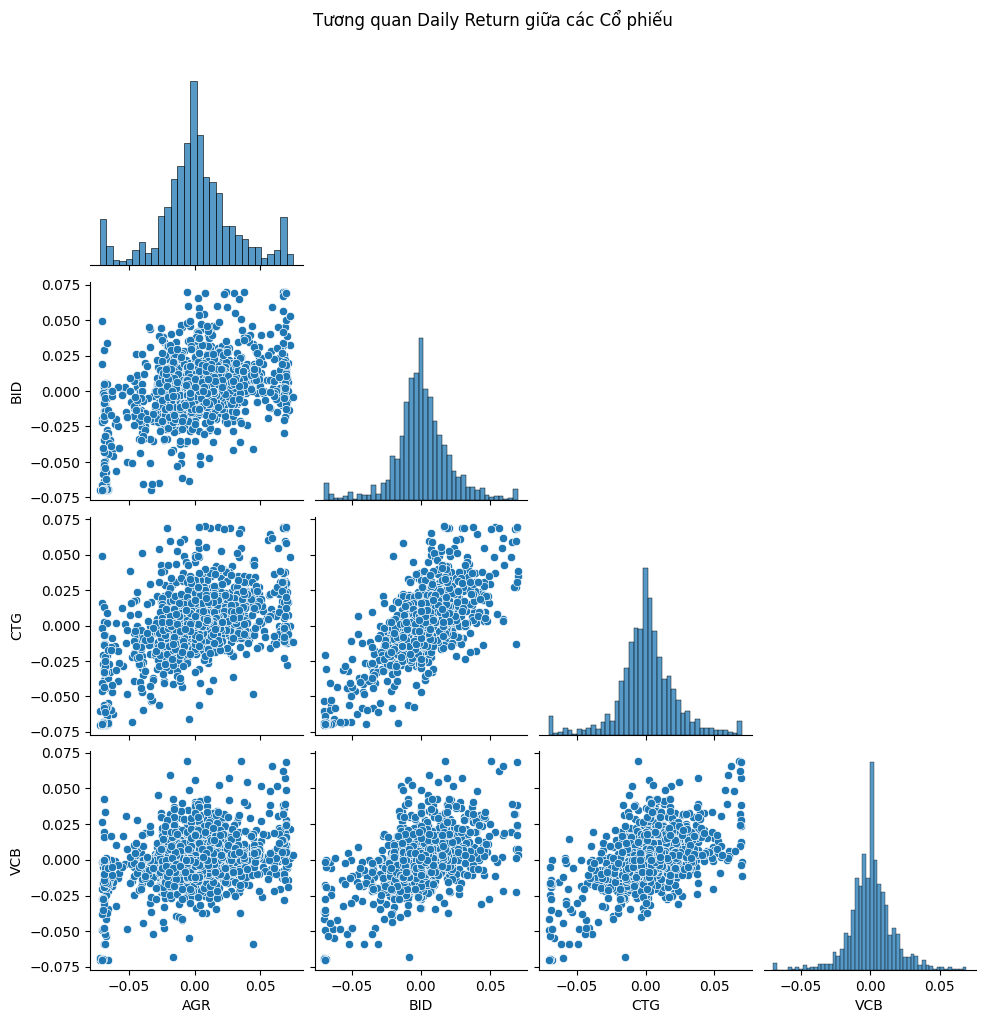

In [58]:
sns.pairplot(returns_df, kind='scatter', corner=True)
plt.suptitle('Tương quan Daily Return giữa các Cổ phiếu', y=1.02)
plt.show()

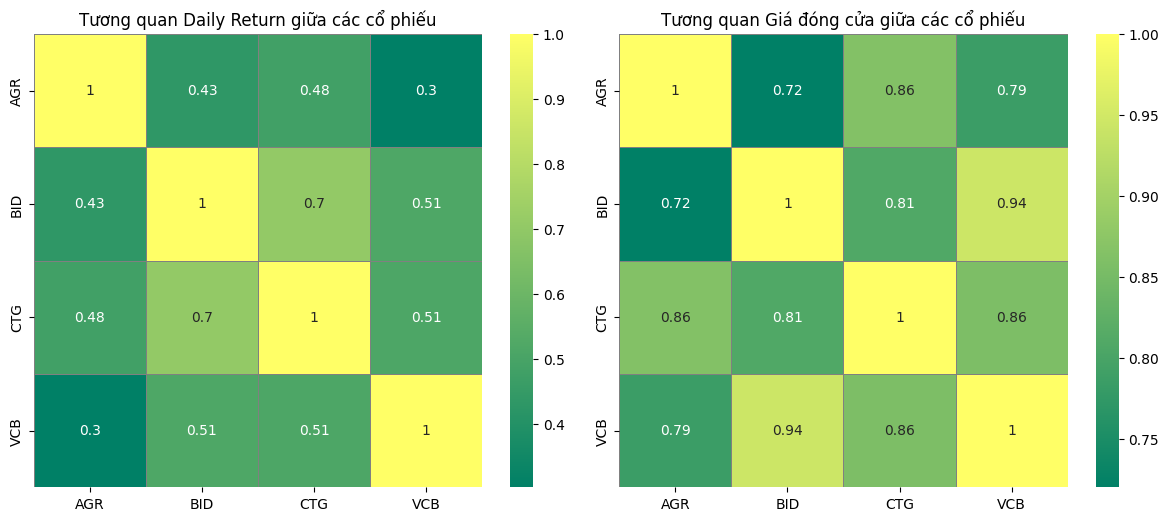

In [60]:
plt.figure(figsize=(12, 10))

# Heatmap tương quan daily return
plt.subplot(2, 2, 1)
sns.heatmap(returns_df.corr(), annot=True, cmap='summer', linewidths=0.5, linecolor='gray')
plt.title('Tương quan Daily Return giữa các cổ phiếu')

# Heatmap tương quan giá đóng cửa
plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer', linewidths=0.5, linecolor='gray')
plt.title('Tương quan Giá đóng cửa giữa các cổ phiếu')

plt.tight_layout()
plt.show()

> Nhận xét:

**1. Tương quan Daily Return giữa các cổ phiếu (trái)**
- AGR có tương quan thấp với các cổ phiếu còn lại: AGR - VCB chỉ 0.30, AGR - BID chỉ 0.43. => AGR có xu hướng biến động độc lập, ít liên kết với thị trường.
- CTG và BID có mức tương quan cao nhất (0.70) => Hai mã này có sự đồng pha rõ rệt trong biến động hàng ngày.

- VCB có tương quan trung bình

**2. Tương quan Giá Đóng Cửa giữa các cổ phiếu (phải)**
- Tất cả các mã cổ phiếu đều có tương quan giá đóng cửa rất cao (trên 0.7) =>Điều này cho thấy về dài hạn, các cổ phiếu ngân hàng thường cùng tăng hoặc giảm.
- VCB - BID đạt tương quan rất cao (0.94) => Hai mã này có xu hướng đồng biến mạnh trong xu hướng giá.
- CTG - AGR cũng có tương quan cao (0.86) => Dù AGR biến động daily thấp, nhưng xu hướng giá dài hạn vẫn khá sát CTG.

### Dự đoán giá đóng cửa của VCB bằng LSTM

In [63]:
df = VCB.copy()
df

,time,open,high,low,close,volume
0,2019-05-20,28810,29370,28770,29240,607060
1,2019-05-21,29280,29500,29200,29200,473170
2,2019-05-22,28980,29590,28900,28980,662700
3,2019-05-23,29070,29320,28940,29160,378440
4,2019-05-24,29020,29320,28510,28680,931250
...,...,...,...,...,...,...
1497,2025-05-14,57200,58800,57200,58700,8014200
1498,2025-05-15,59300,59800,58700,58700,8070600
1499,2025-05-16,58800,59000,57500,57500,8364800
1500,2025-05-19,57400,57600,57000,57000,4784400


- Chúng ta sẽ Dùng 50 ngày liên tục làm cơ sở dự đoán của ngày tiếp theo

- VD: Từ ngày 1 đến ngày 50 sẽ dùng dự đoán cho ngày 51; Từ ngày 2 đến ngày 51 sẽ dùng dự đoán cho ngày 52; ... Tương tự như vậy cho đến hết tập dữ liệu train

In [64]:
train_data = pd.DataFrame(df, columns=['time', 'close'])
train_data

,time,close
0,2019-05-20,29240
1,2019-05-21,29200
2,2019-05-22,28980
3,2019-05-23,29160
4,2019-05-24,28680
...,...,...
1497,2025-05-14,58700
1498,2025-05-15,58700
1499,2025-05-16,57500
1500,2025-05-19,57000


**Xử lý dữ liệu trước khi huấn luyện mô hình**
- Chuẩn hóa dữ liệu, chuyển dữ liệu thành mảng và reshape dữ liệu là một bước cần thiết trước khi đem dữ liệu vào mô hình LSTM

In [66]:
# Chuẩn hóa dữ liệu
train_data_values = train_data['close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(train_data_values)

# Dùng 50 ngày liên tục làm cơ sở dự đoán của ngày tiếp theo
x_train, y_train, times = [], [], []
for i in range(50, len(train_data_values)):
    x_train.append(sc_train[i-50:i, 0])
    y_train.append(sc_train[i, 0])
    times.append(train_data['time'].values[i])
    
# Chuyển đổi dữ liệu thành mảng numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape dữ liệu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

**Tạo và huấn luyện mô hình LSTM**

In [67]:
# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_absolute_error', optimizer='adam')
model_lstm.fit(x_train, y_train, epochs=50, batch_size=50, verbose=2)


Epoch 1/50
30/30 - 5s - loss: 0.1465 - 5s/epoch - 169ms/step
Epoch 2/50
30/30 - 2s - loss: 0.0704 - 2s/epoch - 61ms/step
Epoch 3/50
30/30 - 2s - loss: 0.0696 - 2s/epoch - 61ms/step
Epoch 4/50
30/30 - 2s - loss: 0.0686 - 2s/epoch - 61ms/step
Epoch 5/50
30/30 - 2s - loss: 0.0680 - 2s/epoch - 62ms/step
Epoch 6/50
30/30 - 2s - loss: 0.0628 - 2s/epoch - 61ms/step
Epoch 7/50
30/30 - 2s - loss: 0.0665 - 2s/epoch - 64ms/step
Epoch 8/50
30/30 - 2s - loss: 0.0701 - 2s/epoch - 63ms/step
Epoch 9/50
30/30 - 2s - loss: 0.0619 - 2s/epoch - 70ms/step
Epoch 10/50
30/30 - 2s - loss: 0.0586 - 2s/epoch - 61ms/step
Epoch 11/50
30/30 - 2s - loss: 0.0605 - 2s/epoch - 66ms/step
Epoch 12/50
30/30 - 2s - loss: 0.0559 - 2s/epoch - 62ms/step
Epoch 13/50
30/30 - 2s - loss: 0.0559 - 2s/epoch - 60ms/step
Epoch 14/50
30/30 - 2s - loss: 0.0600 - 2s/epoch - 65ms/step
Epoch 15/50
30/30 - 2s - loss: 0.0557 - 2s/epoch - 65ms/step
Epoch 16/50
30/30 - 2s - loss: 0.0556 - 2s/epoch - 64ms/step
Epoch 17/50
30/30 - 2s - loss: 0

In [68]:
# Dự đoán trên tập huấn luyện
y_predict = model_lstm.predict(x_train)
y_train = sc.inverse_transform(y_train)
y_predict = sc.inverse_transform(y_predict)

46/46 [==============================] - 1s 16ms/step


In [69]:
# Hiển thị giá dự đoán và giá thực tế bằng dataframe
results_df = pd.DataFrame({'time': times, 'Giá thực tế': y_train.flatten(), 'Giá dự đoán': y_predict.flatten()})
results_df

,time,Giá thực tế,Giá dự đoán
0,2019-07-29,34940.0,34018.300781
1,2019-07-30,34760.0,34263.839844
2,2019-07-31,34590.0,34576.269531
3,2019-08-01,34720.0,34809.460938
4,2019-08-02,34110.0,34972.050781
...,...,...,...
1447,2025-05-14,58700.0,56487.359375
1448,2025-05-15,58700.0,56941.699219
1449,2025-05-16,57500.0,57494.238281
1450,2025-05-19,57000.0,57656.964844


In [70]:
# Trực quan hóa so sánh giá dự đoán và giá thực tế
times_str = [str(time) for time in times]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times_str, y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=times_str, y=y_predict.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='red')))

fig.update_layout(
    title='Biểu đồ so sánh giá đóng cửa dự đoán và giá đóng cửa thực tế',
    xaxis_title='Thời gian',
    yaxis_title='Giá',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1 tháng', step='month', stepmode='backward'),
                dict(count=6, label='6 tháng', step='month', stepmode='backward'),
                dict(label='Tất cả',step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

# Show plot
fig.show()


**Chúng ta se thử dự đoán 5 ngày tiếp theo ngoài bộ dữ liệu**
- Chúng ta sẽ 50 ngày cuối cùng trong tập huấn luyện từ đó dự đoán được ngày kế tiếp

In [72]:
# Dự đoán 5 ngày tiếp theo
future_days = 5
last_50_days = sc_train[-50:]  # Lấy 50 ngày cuối cùng trong tập huấn luyện
predicted_future = []
train_data = last_50_days.copy()

for _ in range(future_days):
    # Dự đoán giá ngày tiếp theo
    train_data_reshaped = np.reshape(train_data, (1, train_data.shape[0], 1))
    next_day_prediction = model_lstm.predict(train_data_reshaped)
    
    # Chuyển đổi giá trị dự đoán về dạng gốc
    next_day_prediction_inversed = sc.inverse_transform(next_day_prediction)
    
    # Thêm giá trị dự đoán vào danh sách kết quả
    predicted_future.append(next_day_prediction_inversed[0, 0])
    
    # Thêm giá trị dự đoán vào train_data và loại bỏ giá trị đầu tiên
    train_data = np.append(train_data[1:], next_day_prediction, axis=0)

# Hiển thị giá dự đoán cho 5 ngày tiếp theo
predicted_future = np.array(predicted_future)
print("Dự đoán giá cho 5 ngày tiếp theo:", predicted_future)


1/1 [==============================] - 0s 20ms/step
Dự đoán giá cho 5 ngày tiếp theo: [57222.215 57015.29  56838.61  56684.188 56545.984]


In [73]:
last_time = pd.to_datetime(results_df['time'].iloc[-1])
future_times = [last_time + pd.Timedelta(days=i) for i in range(1, future_days + 1)]
future_df = pd.DataFrame({'time': future_times, 'Giá 5 ngày tiếp theo': predicted_future})
results_df = pd.concat([results_df, future_df], ignore_index=True)
results_df

,time,Giá thực tế,Giá dự đoán,Giá 5 ngày tiếp theo
0,2019-07-29,34940.0,34018.300781,NaN
1,2019-07-30,34760.0,34263.839844,NaN
2,2019-07-31,34590.0,34576.269531,NaN
3,2019-08-01,34720.0,34809.460938,NaN
4,2019-08-02,34110.0,34972.050781,NaN
...,...,...,...,...
1452,2025-05-21,NaN,NaN,57222.214844
1453,2025-05-22,NaN,NaN,57015.289062
1454,2025-05-23,NaN,NaN,56838.609375
1455,2025-05-24,NaN,NaN,56684.187500


In [74]:
# Vẽ biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo
# Lọc dữ liệu từ 5/2024 trở đi
start_date = pd.to_datetime('2024-01-01')
results_df1 = results_df[results_df['time'] >= start_date]

# Vẽ biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo
fig = make_subplots()

fig.add_trace(go.Scatter(
    x=results_df1['time'],
    y=results_df1['Giá thực tế'],
    mode='lines',
    name='Giá thực tế',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=results_df1['time'],
    y=results_df1['Giá dự đoán'],
    mode='lines',
    name='Giá dự đoán',
    line=dict(color='red')
))

# Chỉ thêm dữ liệu tương lai nếu có trong results_df1
if 'Giá 5 ngày tiếp theo' in results_df1.columns:
    fig.add_trace(go.Scatter(
        x=results_df1['time'],
        y=results_df1['Giá 5 ngày tiếp theo'],
        mode='lines',
        name='Giá 5 ngày tiếp theo',
        line=dict(color='green', dash='dash')
    ))

fig.update_layout(
    title='Biểu đồ thể hiện kết quả dự đoán 5 ngày tiếp theo',
    xaxis_title='Thời gian',
    yaxis_title='Giá đóng cửa',
    legend=dict(x=0, y=1),
)

fig.show()

> Dựa vào kết quả dự đoán ta thấy xu hướng giá sẽ giảm trong 5 ngày tiếp theo

In [75]:
# Đánh giá mô hình
r2_lstm = r2_score(y_train, y_predict)
mae_lstm = mean_absolute_error(y_train, y_predict)

print("R^2 Score", r2_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)

R^2 Score 0.9888156696983155
Mean Absolute Error (MAE): 738.0648337960572
